In [32]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

!pip install hmeasure

#### Reading cleaned data 

In [34]:
import pickle
file = open("data_risk2_dummy","rb")
#file = open("data_agegrp_dummy_drop_all_unknowns","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [35]:
X_train.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
X_train.shape

(113829, 40)

In [37]:
X_test.shape

(59501, 40)

In [38]:
#rfecol = ['agegrp_3', 'agegrp_4', 'agegrp_5', 'agegrp_6', 'agegrp_7', 'agegrp_8','agegrp_9', 'agegrp_10', 'density_1', 
#          'density_2', 'race_2', 'race_4', 'nrelbc_1', 'nrelbc_2', 'lastmamm_0']
rfecol = ['menopaus_0', 'agegrp_2', 'agegrp_3', 'agegrp_4', 'agegrp_5',
       'agegrp_6', 'agegrp_7', 'agegrp_8', 'agegrp_9', 'agegrp_10',
       'density_1', 'density_4', 'race_2', 'race_3', 'race_4', 'race_5',
       'hispanic_0', 'hispanic_1', 'bmi_3', 'bmi_4', 'agefirst_1',
       'agefirst_2', 'nrelbc_0', 'nrelbc_2', 'lastmamm_1']

X_train=X_train[rfecol]
X_test=X_test[rfecol]

In [39]:
from imblearn.over_sampling import ADASYN

over = ADASYN(random_state=42, n_jobs=-1)
X_rs, y_rs = over.fit_resample(X_train, y_train)

In [40]:
from collections import Counter

Counter(y_rs)

Counter({0: 109536, 1: 109330})

import pickle
file = open("data_adasyn_75_agegrp_dummy","wb")
pickle.dump(X_rs,file)
pickle.dump(y_rs,file)
pickle.dump(X_test,file)
pickle.dump(y_test,file)
file.close()

In [41]:
import pickle
file = open("data_adasyn_risk2","wb")
pickle.dump(X_rs,file)
pickle.dump(y_rs,file)
pickle.dump(X_test,file)
pickle.dump(y_test,file)
file.close()

In [42]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### 2: Model Building

In [43]:
# Importing LogisticRegression and metrics from sklearn library
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [44]:
### Building model using regularization and cross validation

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

In [45]:
### Building model using regularization and cross validation

# Specify range of hyper-parameters to tune
hyper_params = {'C': [10, 1, 0.5, 0.1, 0.01]}

# Specify model for logistic regression with option to treat class imbalance and perform grid search
logreg = LogisticRegression()

# GridSearchCV
model_cv = GridSearchCV(estimator = logreg,
                       param_grid = hyper_params,
                       scoring = "balanced_accuracy",
                       cv = folds,
                       verbose = 1,
                       return_train_score = True,
                       n_jobs=-1)

# Fit the model
model_cv.fit(X_rs,y_rs)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   44.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.5, 0.1, 0.01]}, return_train_score=True,
             scoring='balanced_accuracy', verbose=1)

In [46]:
# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", model_cv.best_score_)
print("\n")
print(model_cv.best_estimator_)

best balanced accuracy 0.6347666107274135


LogisticRegression(C=0.1)


In [47]:
# It looks that C=0.1 and penalty='l1' are the best value

# Running Logistic Regression on Optimal hyperparameter value
logreg = LogisticRegression(C=0.01)

logreg.fit(X_rs,y_rs)

LogisticRegression(C=0.01)

# Coefficients
logreg.coef_

In [48]:
# List of cols with their coefficients
val=logreg.coef_.reshape(-1)
coef = (pd.DataFrame(val, index = X_train.columns, columns = ['coeff'] ))
coef = coef.sort_values(by = 'coeff', ascending=False)
coef

,coeff
agegrp_8,0.984900
agegrp_7,0.926746
agegrp_9,0.892612
hispanic_0,0.855065
agegrp_6,0.851258
agegrp_5,0.751971
agegrp_10,0.547645
agegrp_4,0.503159
menopaus_0,0.425444
nrelbc_0,0.340336


# Select Cols which have non-zero coefficients
df=pd.DataFrame({'cols':X_train.columns,'coeff':val})
df = df[df.coeff!=0]
col=list(df.cols)
col

In [49]:
y_pred_train=logreg.predict(X_rs)
#y_pred_train=(logreg.predict_proba(X_rs)[:,1] > 0.38).astype(bool)

Confusion Matrix ->
[[67051 42485]
 [37466 71864]]
Accuracy: 0.6347034258404686
Sensitivity: 0.6573127229488704
Specificity: 0.6121366491381829
Average: 0.6347246860435267
Precision 0.6284619891734952
MCC  0.2697215429598515
F1  0.6425636738361671
F2  0.6513325925509682
F3  0.654308994017221
ROC-AUC : 0.67


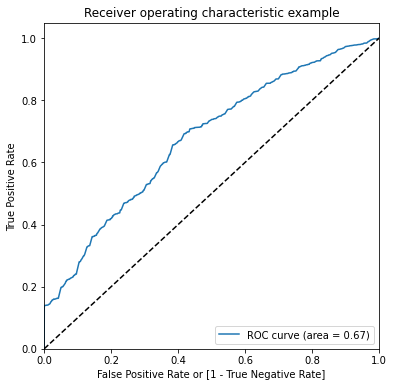

In [50]:
model_stats(X_rs, y_rs, y_pred_train, logreg)

Confusion Matrix ->
[[33712 24218]
 [  595   976]]
Accuracy: 0.5829817986252331
Sensitivity: 0.6212603437301082
Specificity: 0.5819437251855688
Average: 0.6016020344578386
Precision 0.038739382392633165
MCC  0.06593747660929415
F1  0.07293106669157481
F2  0.155028909079357
F3  0.24813769608217018
ROC-AUC : 0.62


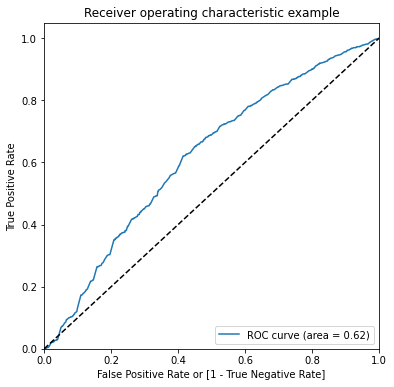

In [51]:
# Running Logistic Regression with class_weight parameter to handle class imbalance
y_pred_test=logreg.predict(X_test)
#y_pred_test=(logreg.predict_proba(X_test)[:,1] > 0.38).astype(bool)

model_stats(X_test, y_test, y_pred_test, logreg)